In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Files already downloaded and verified
Files already downloaded and verified
All class names: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']. Batch size: 32


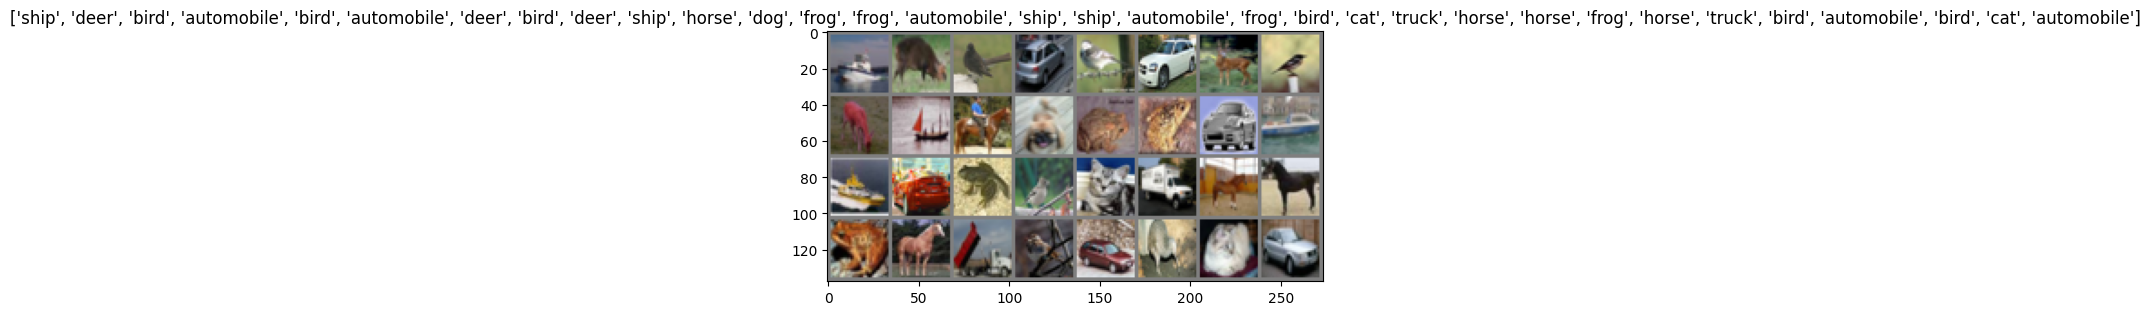

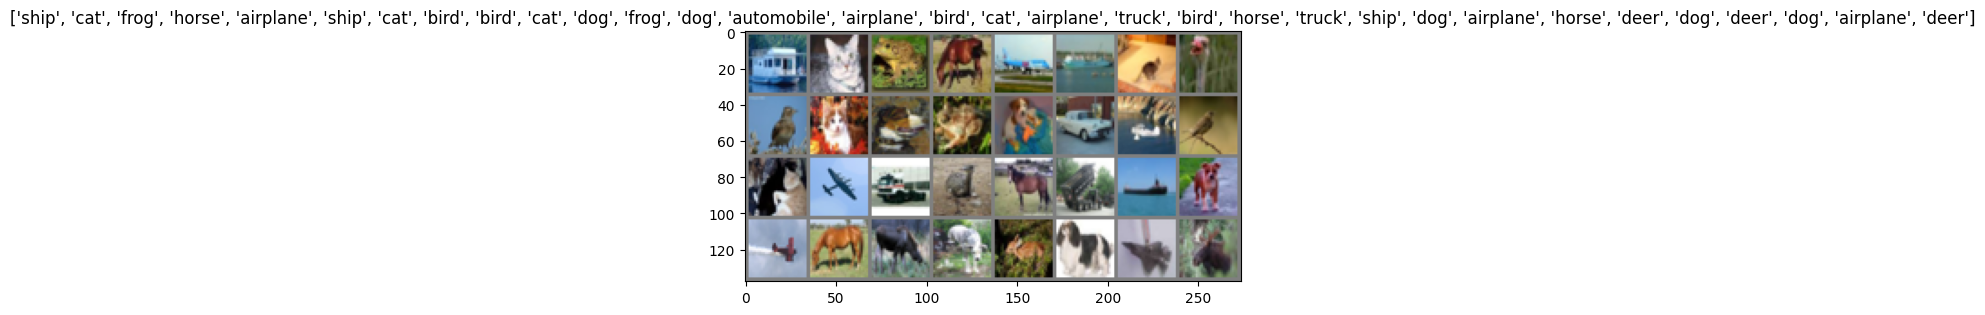

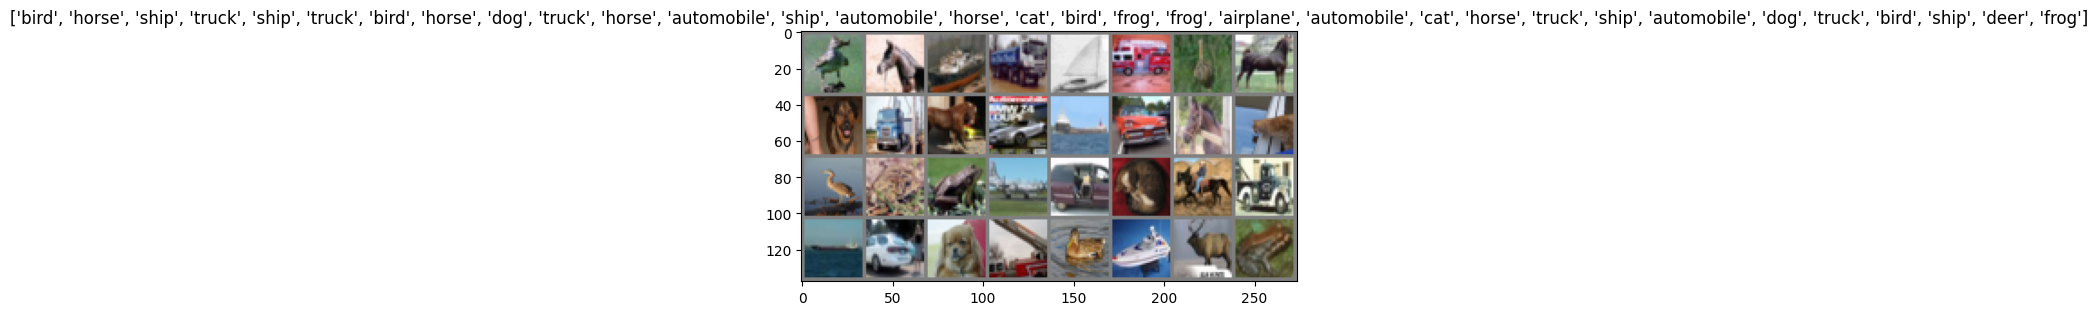

In [9]:
mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.5, 0.5, 0.5])

data_transforms = {
    'train': transforms.Compose([
#        transforms.RandomResizedCrop(224),
#        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'val': transforms.Compose([
#        transforms.Resize(256),
#        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
}


local_data = False

if local_data:
    data_dir = './cifar10_mini'
    image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                              data_transforms[x])
                      for x in ['train', 'val']}
    n_epochs = 10
    batchsize = 2*len(class_names)
else:
    image_datasets = {x: torchvision.datasets.CIFAR10(root='./data', train=(x=='train'),
                                                     download=True,
                                                     transform=data_transforms[x])
                      for x in ['train', 'val']}
    n_epochs = 2
    batchsize = 32


class_names = image_datasets['val'].classes

print(f'All class names: {class_names}. Batch size: {batchsize}')

dataloders = {x: torch.utils.data.DataLoader(image_datasets[x],
                                             batch_size=batchsize,
                                             shuffle=(x=='train'))
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

def imshow(inp, title):
    inp = inp.numpy().transpose(1, 2, 0)
    inp = inp * std + mean # unnormalize

    inp = np.clip(inp, 0, 1) # === inp.squeeze(2)
    plt.imshow(inp)
    plt.title(title)
    plt.show()

for i, (imgs, labels) in enumerate(dataloders['train']):
    grid = torchvision.utils.make_grid(imgs)
    imshow(grid, title=[class_names[x] for x in labels])
    if i==2:
        break


#### In validation phase, save the best model and return it

In [10]:
n_total_iter = len(dataloders['train'])

def train_model(model, criterion, scheduler, n_epochs):
    begin = time.time()

    best_model = copy.deepcopy(model.state_dict())
    best_acc = 0

    for epoch in range(n_epochs):
        print(f'Epoch {epoch+1}/{n_epochs}')
        print('-' * 15)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train() # set model to training mode
            else:
                model.eval() # evaluation mode

            total_loss = 0
            total_corrects = 0

            # iterate over data
            for i, (inputs, labels) in enumerate(dataloders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # forward pass
                with torch.set_grad_enabled(phase=='train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward
                    if phase=='train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()
                        if (i+1) % 200==0:
                            print(f'Iteration {i+1}/{n_total_iter}: Loss = {loss:.4f}')

                total_loss += loss.item() * inputs.size(0)
                total_corrects += (preds==labels).sum()

        # end of 'for phase' - one epoch training/val is done

        if phase=='train':
            scheduler.step()

        epoch_loss = total_loss / dataset_sizes[phase]
        epoch_acc = total_corrects / dataset_sizes[phase]

        print(f'{phase} Loss: {epoch_loss:.4f} {phase} Acc: {epoch_acc:.3f}')

        if phase=='val' and epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model = copy.deepcopy(model.state_dict()) # best_model = model is wrong


    time_elapsed = time.time() - begin
    print('\nTraining completed in {:.0f}m {:.0f}s'.format(time_elapsed//60, time_elapsed%60))
    print(f'Best val Acc: {best_acc:.4f}. Returning the best model.')

    return best_model


In [11]:
print('**** BASELINE: Retrain the entire model ***')
############ Retrain the entire CNN
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
n_feats = model.fc.in_features
model.fc = nn.Linear(n_feats, len(class_names))

## training
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# for every 7 epochs, decay LR by a factor of 0.1
lr_scheduler1 = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

model = train_model(model, criterion, lr_scheduler1, n_epochs)

############ Transfer Learning
print('\n**** TRANSFER LEARNING: finetuning the FC layers only ***')
model_trf = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
for param in model_trf.parameters():
    param.requires_grad = False

n_feats = model_trf.fc.in_features
model_trf.fc = nn.Linear(n_feats, len(class_names))

model_trf = model_trf.to(device)

criterion = nn.CrossEntropyLoss()
optimizer_trf = optim.SGD(model_trf.fc.parameters(), lr=0.001)

# for every 7 epochs, decay LR by a factor of 0.1
lr_scheduler2 = lr_scheduler.StepLR(optimizer_trf, step_size=7, gamma=0.1)

model_trf = train_model(model_trf, criterion, lr_scheduler2, n_epochs)


**** BASELINE: Retrain the entire model ***
Epoch 1/2
---------------
Iteration 200/1563: Loss = 1.5657
Iteration 400/1563: Loss = 1.0057
Iteration 600/1563: Loss = 0.6759
Iteration 800/1563: Loss = 0.9815
Iteration 1000/1563: Loss = 1.2754
Iteration 1200/1563: Loss = 0.6670
Iteration 1400/1563: Loss = 0.7913
val Loss: 0.7010 val Acc: 0.757
Epoch 2/2
---------------
Iteration 200/1563: Loss = 0.6493
Iteration 400/1563: Loss = 0.7318
Iteration 600/1563: Loss = 0.7535
Iteration 800/1563: Loss = 0.8329
Iteration 1000/1563: Loss = 0.6757
Iteration 1200/1563: Loss = 0.6110
Iteration 1400/1563: Loss = 0.4745
val Loss: 0.6029 val Acc: 0.791

Training completed in 1m 20s
Best val Acc: 0.7909. Returning the best model.

**** TRANSFER LEARNING: finetuning the FC layers only ***
Epoch 1/2
---------------
Iteration 200/1563: Loss = 2.5544
Iteration 400/1563: Loss = 2.8092
Iteration 600/1563: Loss = 2.6529
Iteration 800/1563: Loss = 2.6322
Iteration 1000/1563: Loss = 2.6021
Iteration 1200/1563: Los

## Transfer Learning using ResNet18 on CIFAR10

In [12]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Define the transformations for CIFAR10
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

# Load the CIFAR10 dataset
trainset = CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=32, shuffle=True, num_workers=2)
# valset = CIFAR10(root='./data', train=False, download=True, transform=transform)
# valoader = DataLoader(valset, batch_size=32, shuffle=False, num_workers=2)

# Load the pre-trained ResNet18 model
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)  # 'pretrained=True' is deprecated

# Freeze the pre-trained layers (set requires_grad to False)
for param in model.parameters():
    param.requires_grad = False

# Replace the last fully connected layer with a new one for CIFAR10 (10 classes)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)

# Define a loss function and an optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.fc.parameters(), lr=0.001, momentum=0.9)

# Training loop
model = model.to(device)
num_epochs = 5
for epoch in range(num_epochs):
    running_loss = 0.0
    n_total = 0
    n_correct = 0
    for i, data in enumerate(trainloader, 0):
        # Get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        _, preds = outputs.max(axis=1)
        n_correct += (preds==labels).sum()
        n_total += len(labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print statistics
        running_loss += loss.item()
        if i % 200 == 199:    # Print every 200 mini-batches
            print('[%d, %5d] avg loss: %.3f training_accuracy: %.3f' %
                  (epoch + 1, i + 1, running_loss / 200, n_correct/n_total)  )
            running_loss = 0.0

print('Finished Training')

# Save the trained model
torch.save(model.state_dict(), 'resnet18_cifar10_transferred.pth')

Files already downloaded and verified


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[1,   200] avg loss: 2.024 training_accuracy: 0.283
[1,   400] avg loss: 1.771 training_accuracy: 0.328
[1,   600] avg loss: 1.761 training_accuracy: 0.345
[1,   800] avg loss: 1.685 training_accuracy: 0.362
[1,  1000] avg loss: 1.686 training_accuracy: 0.372
[1,  1200] avg loss: 1.665 training_accuracy: 0.380
[1,  1400] avg loss: 1.651 training_accuracy: 0.385
[2,   200] avg loss: 1.623 training_accuracy: 0.426
[2,   400] avg loss: 1.630 training_accuracy: 0.429
[2,   600] avg loss: 1.630 training_accuracy: 0.429
[2,   800] avg loss: 1.610 training_accuracy: 0.431
[2,  1000] avg loss: 1.633 training_accuracy: 0.431
[2,  1200] avg loss: 1.621 training_accuracy: 0.432
[2,  1400] avg loss: 1.613 training_accuracy: 0.433
[3,   200] avg loss: 1.601 training_accuracy: 0.439
[3,   400] avg loss: 1.621 training_accuracy: 0.434
[3,   600] avg loss: 1.589 training_accuracy: 0.435
[3,   800] avg loss: 1.620 training_accuracy: 0.436
[3,  1000] avg loss: 1.633 training_accuracy: 0.435
[3,  1200] a